# scRNA-seq: B lymphocytes treated with a novel IL-10 inducer

## --- Differential expression ---

## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>

# 0. Loading the libraries

[Timing: 50s]

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as grid_spec
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
from sklearn.neighbors import KernelDensity
import joypy
import scrublet as scr
import scvelo as scv
import gseapy as gp
from gseapy.plot import barplot, dotplot

from matplotlib_venn import venn3, venn2
import diffxpy.api as de
from bioinfokit import analys, visuz
import xlsxwriter

import normalisr.normalisr as norm
from os.path import join as pjoin
import statsmodels
from adjustText import adjust_text

import pickle
import os

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

2022-06-17 11:50:45.651378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib:
2022-06-17 11:50:45.651461: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi_save=300)
#sc.logging.print_versions()

# 1. Reading in the data

[Timing: 35s reading from cache]

In [3]:
# Load the pre-processed data

with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [4]:
from pyorthomap import findOrthologsMmHs

translated = findOrthologsMmHs(from_filters = 'external_gene_name',
                               from_values = adata.var.index.tolist()).map()

  0%|          | 0/49 [00:00<?, ?it/s]

In [5]:
def replace(x):
    if len(x.tolist()) == 1:
        if x.tolist()[0] != x.tolist()[0]:
            return "NA"
        else:
            return(x.tolist()[0])
    else:
        return "NA"

adata.var['human_name'] = [replace(translated[translated.external_gene_name == e]["hgnc_symbol"]) for e in adata.var['gene_name']]

In [6]:
adata = adata[:,~(adata.var.human_name == "NA")]
adata.var = adata.var[~(adata.var.human_name == "NA")]
adata.var = adata.var.set_index("human_name")

In [12]:
adata0 = adata.copy()
adata1 = adata[adata.obs['cond'] == 'N6'].copy()
adata2 = adata[adata.obs['tp'] == '48h'].copy()
adata3 = adata[adata.obs['sample2'] == 'N6-48h'].copy()
adata4 = adata[adata.obs['sample2'] == 'N6-2h'].copy()

In [13]:
for data in [adata3]: #adata0, adata1, adata2, adata3
    # Calculate the visualizations
    sc.pp.pca(data, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(data)

    sc.tl.umap(data)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


In [7]:
names = ["all", "N6", "48h", "N6-48h", "irf4", "n6resp"]

In [8]:
save_folder = "decoupler/"
sc.settings.figdir = './'+save_folder

In [ ]:
adata4.obs['Irf4_high'] = adata4.obs['clusters'] == 'N6'
adata4.obs['Gm7972_positive'] = adata4.obs['clusters'] == 'DMSO'

# 2. DecoupleR

In [9]:
import decoupler as dc

In [10]:
def run_decoupler(data, net, groupkey, name):
    
    mat = pd.DataFrame(data.X, columns = data.var_names, index = data.obs_names)

    test = dc.decouple(mat=mat, net=net, methods = ['mlm', 'ulm', 'ora', 'aucell'],verbose=True)

    data.obsm['test_estimate'], data.obsm['test_pvals'] = test['consensus_estimate'], test['consensus_pvals']
    acts = dc.get_acts(data, obsm_key='test_estimate')
    mean_acts = dc.summarize_acts(acts, groupby=groupkey, min_std=0.1) #0.3
    diffs = abs(mean_acts.diff().iloc[1,:])
    mean_acts = mean_acts.filter(diffs.nlargest(30).index.tolist())
    rats = mean_acts.pct_change().iloc[1,:]

    
    l = diffs.nlargest(min(len(diffs//2), 3)).index.tolist() + rats.nsmallest(min(len(diffs//2), 3)).index.tolist()
    sc.pl.umap(acts, color=l+['log_il10', groupkey], cmap='coolwarm', vcenter=0, size = 40, ncols=4, show=False, save="_"+name+".png")
    
    mean_acts = mean_acts.filter(rats.nlargest(min(len(rats//2), 15)).index.tolist() + rats.nsmallest(min(len(rats//2), 15)).index.tolist())
    plot = sb.clustermap(mean_acts, center=0, xticklabels=mean_acts.columns, cmap='coolwarm')
    plot.fig.savefig(save_folder+"heatmap_"+name+".png")
    plt.close()

## 2.1 Transcription factor activity inference

In [15]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])

In [32]:
mat = pd.DataFrame(adata.X, columns = adata.var_names, index = adata.obs_names)
test = dc.decouple(mat=mat, net=net, methods = ['mlm', 'ulm', 'ora', 'aucell'],verbose=True)

Running mlm on mat with 29695 samples and 10276 targets for 140 sources.


100%|██████████| 3/3 [00:55<00:00, 18.52s/it]


Running ulm on mat with 29695 samples and 10276 targets for 140 sources.
Running ora on mat with 29695 samples and 10276 targets for 140 sources.


100%|██████████| 29695/29695 [02:20<00:00, 211.54it/s]


Running aucell on mat with 29695 samples and 10276 targets for 140 sources.


In [33]:
adata.obsm['test_estimate'], adata.obsm['test_pvals'] = test['consensus_estimate'], test['consensus_pvals']
acts = dc.get_acts(adata, obsm_key='test_estimate')

In [36]:
save_object(adata.obsm['test_estimate'], 'saved_objects/tf_activity.pkl')

In [64]:
analysis_name = "TF_"
run_decoupler(adata3, net, 'Il10_positive', analysis_name+names[3])

Running mlm on mat with 6728 samples and 10276 targets for 140 sources.


100%|██████████| 1/1 [00:08<00:00,  8.34s/it]


Running ulm on mat with 6728 samples and 10276 targets for 140 sources.
Running ora on mat with 6728 samples and 10276 targets for 140 sources.


100%|██████████| 6728/6728 [00:40<00:00, 168.17it/s]


Running aucell on mat with 6728 samples and 10276 targets for 140 sources.


In [296]:
analysis_name = "TF_"
run_decoupler(adata4, net, 'Irf4_high', analysis_name+names[4])
run_decoupler(adata4, net, 'Gm7972_positive', analysis_name+names[5])

Running mlm on mat with 2225 samples and 10276 targets for 140 sources.


100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


Running ulm on mat with 2225 samples and 10276 targets for 140 sources.
Running ora on mat with 2225 samples and 10276 targets for 140 sources.


100%|██████████| 2225/2225 [00:14<00:00, 157.24it/s]


Running aucell on mat with 2225 samples and 10276 targets for 140 sources.
Running mlm on mat with 2225 samples and 10276 targets for 140 sources.


100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


Running ulm on mat with 2225 samples and 10276 targets for 140 sources.
Running ora on mat with 2225 samples and 10276 targets for 140 sources.


100%|██████████| 2225/2225 [00:13<00:00, 165.73it/s]


Running aucell on mat with 2225 samples and 10276 targets for 140 sources.


In [297]:
analysis_name = "TF_"
run_decoupler(adata0, net, 'sample2', analysis_name+names[0])
run_decoupler(adata1, net, 'tp', analysis_name+names[1])
run_decoupler(adata2, net, 'cond', analysis_name+names[2])
run_decoupler(adata3, net, 'Il10_positive', analysis_name+names[3])

Running mlm on mat with 29696 samples and 10276 targets for 140 sources.


100%|██████████| 3/3 [00:46<00:00, 15.45s/it]


Running ulm on mat with 29696 samples and 10276 targets for 140 sources.
Running ora on mat with 29696 samples and 10276 targets for 140 sources.


100%|██████████| 29696/29696 [04:47<00:00, 103.27it/s]


Running aucell on mat with 29696 samples and 10276 targets for 140 sources.
Running mlm on mat with 13712 samples and 10276 targets for 140 sources.


100%|██████████| 2/2 [00:22<00:00, 11.34s/it]


Running ulm on mat with 13712 samples and 10276 targets for 140 sources.
Running ora on mat with 13712 samples and 10276 targets for 140 sources.


100%|██████████| 13712/13712 [01:24<00:00, 162.38it/s]


Running aucell on mat with 13712 samples and 10276 targets for 140 sources.
Running mlm on mat with 7755 samples and 10276 targets for 140 sources.


100%|██████████| 1/1 [00:10<00:00, 10.28s/it]


Running ulm on mat with 7755 samples and 10276 targets for 140 sources.
Running ora on mat with 7755 samples and 10276 targets for 140 sources.


100%|██████████| 7755/7755 [00:49<00:00, 155.45it/s]


Running aucell on mat with 7755 samples and 10276 targets for 140 sources.
Running mlm on mat with 6728 samples and 10276 targets for 140 sources.


100%|██████████| 1/1 [00:11<00:00, 11.12s/it]


Running ulm on mat with 6728 samples and 10276 targets for 140 sources.
Running ora on mat with 6728 samples and 10276 targets for 140 sources.


100%|██████████| 6728/6728 [00:43<00:00, 154.84it/s]


Running aucell on mat with 6728 samples and 10276 targets for 140 sources.


In [20]:
net[net.target == 'AFF1']

,source,confidence,target,weight
6105,FOXP1,B,AFF1,0.500000
6867,TAL1,B,AFF1,0.500000
7056,FOXA1,B,AFF1,0.500000
7755,STAT1,B,AFF1,0.500000
7897,HNF4A,B,AFF1,0.500000
8514,SPI1,B,AFF1,0.500000
9262,GATA2,B,AFF1,0.500000
9788,GATA3,B,AFF1,0.500000
10034,E2F1,B,AFF1,0.500000
11473,CEBPA,B,AFF1,0.500000


In [16]:
net[net.source == 'AFF1']

,source,confidence,target,weight


In [17]:
net[net.source == 'RERE']

,source,confidence,target,weight


In [300]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 108))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,35))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [301]:
list_markers = ["FCER2", "BLK", "CFLAR", "CIITA", "ELF4", "ITGB7", "FCRL5"]
for mark in list_markers:
    adata3.obs['Expression of '+mark] = np.log1p(adata3.X[:, adata3.var.index == mark])

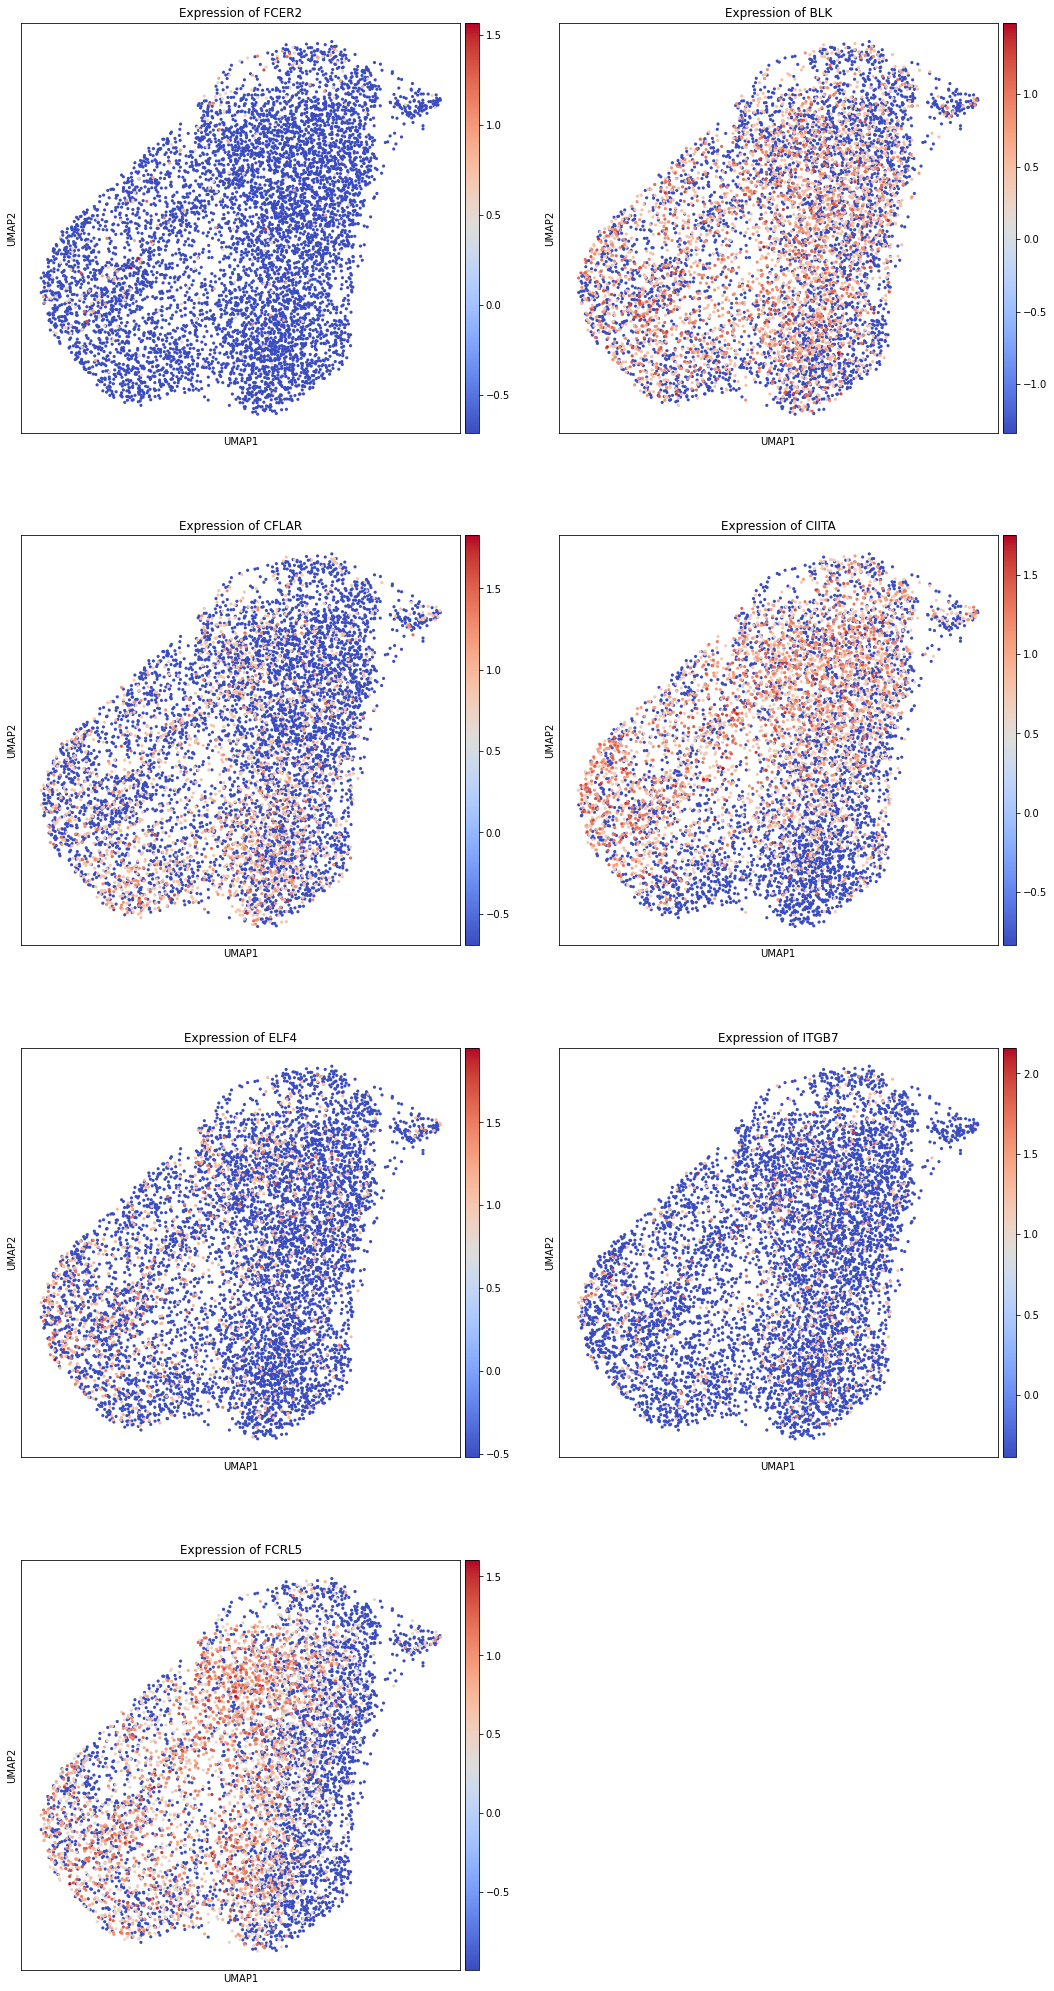

In [302]:
to_show = ['Expression of '+mark for mark in list_markers]
sc.pl.umap(adata3, cmap = "coolwarm", color = to_show, size = 40, add_outline = False, ncols = 2, save = "_irf4.png")

## 2.2 Pathway activity inference

In [11]:
net = dc.get_progeny(organism='human', top=100)
net

  0%|          | 0.00/39.0M [00:00<?, ?B/s]

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


In [304]:
analysis_name = "PA_"
run_decoupler(adata4, net, 'Irf4_high', analysis_name+names[4])
run_decoupler(adata4, net, 'Gm7972_positive', analysis_name+names[5])

Running mlm on mat with 2225 samples and 10276 targets for 14 sources.


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Running ulm on mat with 2225 samples and 10276 targets for 14 sources.
Running ora on mat with 2225 samples and 10276 targets for 14 sources.


100%|██████████| 2225/2225 [00:12<00:00, 171.22it/s]


Running aucell on mat with 2225 samples and 10276 targets for 14 sources.
Running mlm on mat with 2225 samples and 10276 targets for 14 sources.


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Running ulm on mat with 2225 samples and 10276 targets for 14 sources.
Running ora on mat with 2225 samples and 10276 targets for 14 sources.


100%|██████████| 2225/2225 [00:13<00:00, 170.90it/s]


Running aucell on mat with 2225 samples and 10276 targets for 14 sources.


In [305]:
analysis_name = "PA_"
run_decoupler(adata0, net, 'sample2', analysis_name+names[0])
run_decoupler(adata1, net, 'tp', analysis_name+names[1])
run_decoupler(adata2, net, 'cond', analysis_name+names[2])
run_decoupler(adata3, net, 'Il10_positive', analysis_name+names[3])

Running mlm on mat with 29696 samples and 10276 targets for 14 sources.


100%|██████████| 3/3 [00:35<00:00, 11.94s/it]


Running ulm on mat with 29696 samples and 10276 targets for 14 sources.
Running ora on mat with 29696 samples and 10276 targets for 14 sources.


100%|██████████| 29696/29696 [04:44<00:00, 104.22it/s]


Running aucell on mat with 29696 samples and 10276 targets for 14 sources.
Running mlm on mat with 13712 samples and 10276 targets for 14 sources.


100%|██████████| 2/2 [00:17<00:00,  8.74s/it]


Running ulm on mat with 13712 samples and 10276 targets for 14 sources.
Running ora on mat with 13712 samples and 10276 targets for 14 sources.


100%|██████████| 13712/13712 [01:22<00:00, 165.68it/s]


Running aucell on mat with 13712 samples and 10276 targets for 14 sources.
Running mlm on mat with 7755 samples and 10276 targets for 14 sources.


100%|██████████| 1/1 [00:09<00:00,  9.43s/it]


Running ulm on mat with 7755 samples and 10276 targets for 14 sources.
Running ora on mat with 7755 samples and 10276 targets for 14 sources.


100%|██████████| 7755/7755 [00:45<00:00, 169.76it/s]


Running aucell on mat with 7755 samples and 10276 targets for 14 sources.
Running mlm on mat with 6728 samples and 10276 targets for 14 sources.


100%|██████████| 1/1 [00:07<00:00,  7.67s/it]


Running ulm on mat with 6728 samples and 10276 targets for 14 sources.
Running ora on mat with 6728 samples and 10276 targets for 14 sources.


100%|██████████| 6728/6728 [00:39<00:00, 171.44it/s]


Running aucell on mat with 6728 samples and 10276 targets for 14 sources.


In [306]:
net[net.source == 'JAK-STAT'][:15]

,source,target,weight,p_value
400,JAK-STAT,OAS1,15.028714,1.057980e-41
401,JAK-STAT,HERC6,8.769676,1.345041e-38
402,JAK-STAT,OAS3,10.618842,1.214358e-37
403,JAK-STAT,PLSCR1,8.481604,8.955206e-37
404,JAK-STAT,DDX60,12.198234,9.150971e-36
405,JAK-STAT,TRIM21,6.674188,1.299265e-35
406,JAK-STAT,SP110,8.678713,2.148256e-35
407,JAK-STAT,DDX58,12.965378,2.650406e-35
408,JAK-STAT,RSAD2,22.898727,2.801133e-35
409,JAK-STAT,STAT1,9.083937,3.529056e-35


## 2.3 Functional enrichment of 'Hallmark' gene sets

In [11]:
net = dc.get_resource('MSigDB')
# Filter by hallmark
net = net[net['collection']=='hallmark']

# Remove duplicated entries
net = net[~net.duplicated(['geneset', 'genesymbol'])]
net = dc.rename_net(net, source='geneset', target='genesymbol', weight=None)
net

label,source,target,weight
11,HALLMARK_TNFA_SIGNALING_VIA_NFKB,MSC,1.0
149,HALLMARK_TNFA_SIGNALING_VIA_NFKB,ICOSLG,1.0
223,HALLMARK_INFLAMMATORY_RESPONSE,ICOSLG,1.0
270,HALLMARK_ALLOGRAFT_REJECTION,ICOSLG,1.0
398,HALLMARK_HYPOXIA,FOSL2,1.0
...,...,...,...
878342,HALLMARK_PANCREAS_BETA_CELLS,FOXO1,1.0
878418,HALLMARK_PANCREAS_BETA_CELLS,GCG,1.0
878512,HALLMARK_PANCREAS_BETA_CELLS,PDX1,1.0
878605,HALLMARK_PANCREAS_BETA_CELLS,INS,1.0


In [15]:
data = adata
name = "upr"
groupkey = "cond"

In [13]:
mat = pd.DataFrame(data.X, columns = data.var_names, index = data.obs_names)
test = dc.decouple(mat=mat, net=net, methods = ['mlm', 'ulm', 'ora', 'aucell'],verbose=True)

data.obsm['test_estimate'], data.obsm['test_pvals'] = test['consensus_estimate'], test['consensus_pvals']
acts = dc.get_acts(data, obsm_key='test_estimate')

Running mlm on mat with 37425 samples and 10561 targets for 50 sources.


100%|██████████| 4/4 [00:48<00:00, 12.25s/it]


Running ulm on mat with 37425 samples and 10561 targets for 50 sources.
Running ora on mat with 37425 samples and 10561 targets for 50 sources.


100%|██████████| 37425/37425 [03:40<00:00, 169.76it/s]


Running aucell on mat with 37425 samples and 10561 targets for 50 sources.


In [16]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.pl.umap(acts, color=['HALLMARK_UNFOLDED_PROTEIN_RESPONSE', groupkey], cmap='coolwarm', vcenter=0, size = 40, ncols=4, show=False, save="_"+name+".png")

[<AxesSubplot:title={'center':'HALLMARK_UNFOLDED_PROTEIN_RESPONSE'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'cond'}, xlabel='UMAP1', ylabel='UMAP2'>]

computing density on 'umap'
--> added
    'umap_density_Il10_positive', densities (adata.obs)
    'umap_density_Il10_positive_params', parameter (adata.uns)
computing density on 'umap'
--> added
    'umap_density_Il10_high', densities (adata.obs)
    'umap_density_Il10_high_params', parameter (adata.uns)


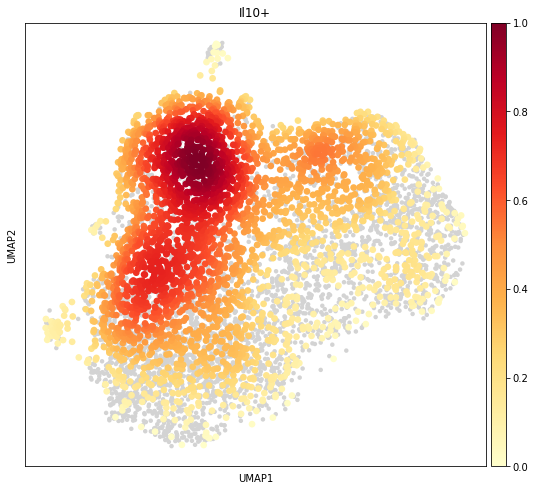

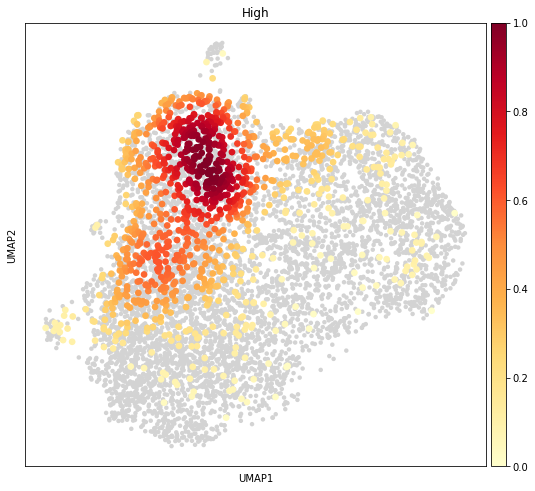

In [24]:
#Compute density on UMAP
marker = 'Il10'
sc.tl.embedding_density(data, basis='umap', groupby=marker+'_positive')
sc.tl.embedding_density(data, basis='umap', groupby=marker+'_high')

sc.pl.embedding_density(data, basis='umap', key='umap_density_'+marker+'_positive', group=marker+'+', save=marker+"pos_cells_post_n648h.png")
sc.pl.embedding_density(data, basis='umap', key='umap_density_'+marker+'_high', group='High', save=marker+"hi_cells_post_n648h.png")

In [308]:
analysis_name = "HM_"
run_decoupler(adata4, net, 'Irf4_high', analysis_name+names[4])
run_decoupler(adata4, net, 'Gm7972_positive', analysis_name+names[5])

Running mlm on mat with 2225 samples and 10276 targets for 50 sources.


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Running ulm on mat with 2225 samples and 10276 targets for 50 sources.
Running ora on mat with 2225 samples and 10276 targets for 50 sources.


100%|██████████| 2225/2225 [00:12<00:00, 171.37it/s]


Running aucell on mat with 2225 samples and 10276 targets for 50 sources.
Running mlm on mat with 2225 samples and 10276 targets for 50 sources.


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Running ulm on mat with 2225 samples and 10276 targets for 50 sources.
Running ora on mat with 2225 samples and 10276 targets for 50 sources.


100%|██████████| 2225/2225 [00:13<00:00, 169.81it/s]


Running aucell on mat with 2225 samples and 10276 targets for 50 sources.


In [309]:
analysis_name = "HM_"
run_decoupler(adata0, net, 'sample2', analysis_name+names[0])
run_decoupler(adata1, net, 'tp', analysis_name+names[1])
run_decoupler(adata2, net, 'cond', analysis_name+names[2])
run_decoupler(adata3, net, 'Il10_positive', analysis_name+names[3])

Running mlm on mat with 29696 samples and 10276 targets for 50 sources.


100%|██████████| 3/3 [00:57<00:00, 19.15s/it]


Running ulm on mat with 29696 samples and 10276 targets for 50 sources.
Running ora on mat with 29696 samples and 10276 targets for 50 sources.


100%|██████████| 29696/29696 [03:00<00:00, 164.48it/s]


Running aucell on mat with 29696 samples and 10276 targets for 50 sources.
Running mlm on mat with 13712 samples and 10276 targets for 50 sources.


100%|██████████| 2/2 [00:17<00:00,  8.76s/it]


Running ulm on mat with 13712 samples and 10276 targets for 50 sources.
Running ora on mat with 13712 samples and 10276 targets for 50 sources.


100%|██████████| 13712/13712 [01:26<00:00, 158.94it/s]


Running aucell on mat with 13712 samples and 10276 targets for 50 sources.
Running mlm on mat with 7755 samples and 10276 targets for 50 sources.


100%|██████████| 1/1 [00:09<00:00,  9.59s/it]


Running ulm on mat with 7755 samples and 10276 targets for 50 sources.
Running ora on mat with 7755 samples and 10276 targets for 50 sources.


100%|██████████| 7755/7755 [00:50<00:00, 154.30it/s]


Running aucell on mat with 7755 samples and 10276 targets for 50 sources.
Running mlm on mat with 6728 samples and 10276 targets for 50 sources.


100%|██████████| 1/1 [00:08<00:00,  8.14s/it]


Running ulm on mat with 6728 samples and 10276 targets for 50 sources.
Running ora on mat with 6728 samples and 10276 targets for 50 sources.


100%|██████████| 6728/6728 [00:59<00:00, 112.93it/s]


Running aucell on mat with 6728 samples and 10276 targets for 50 sources.


## 2.3 Functional enrichment of other gene sets

In [310]:
net = dc.get_resource('KEGG-PC')

# Remove duplicated entries
net = net[~net.duplicated(['pathway', 'genesymbol'])]

net = dc.rename_net(net, source='pathway', target='genesymbol', weight=None)
net

label,source,target,weight
0,Glycolysis / Gluconeogenesis,A8K7J7,1.0
1,Butirosin and neomycin biosynthesis,A8K7J7,1.0
2,Galactose metabolism,A8K7J7,1.0
3,Amino sugar and nucleotide sugar metabolism,A8K7J7,1.0
4,Fructose and mannose metabolism,A8K7J7,1.0
...,...,...,...
1862,Metabolic pathways,PRDX4,1.0
1863,Metabolic pathways,MTM1,1.0
1864,Metabolic pathways,ASPG,1.0
1865,Metabolic pathways,CMBL,1.0


In [311]:
analysis_name = "Metabo_"
run_decoupler(adata4, net, 'Irf4_high', analysis_name+names[4])
run_decoupler(adata4, net, 'Gm7972_positive', analysis_name+names[5])

Running mlm on mat with 2225 samples and 10276 targets for 59 sources.


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


Running ulm on mat with 2225 samples and 10276 targets for 59 sources.
Running ora on mat with 2225 samples and 10276 targets for 59 sources.


100%|██████████| 2225/2225 [00:29<00:00, 75.28it/s]


Running aucell on mat with 2225 samples and 10276 targets for 59 sources.
Running mlm on mat with 2225 samples and 10276 targets for 59 sources.


100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Running ulm on mat with 2225 samples and 10276 targets for 59 sources.
Running ora on mat with 2225 samples and 10276 targets for 59 sources.


100%|██████████| 2225/2225 [00:28<00:00, 76.93it/s]


Running aucell on mat with 2225 samples and 10276 targets for 59 sources.


In [312]:
analysis_name = "Metabo_"
run_decoupler(adata0, net, 'sample2', analysis_name+names[0])
run_decoupler(adata1, net, 'tp', analysis_name+names[1])
run_decoupler(adata2, net, 'cond', analysis_name+names[2])
run_decoupler(adata3, net, 'Il10_positive', analysis_name+names[3])

Running mlm on mat with 29696 samples and 10276 targets for 59 sources.


100%|██████████| 3/3 [00:40<00:00, 13.52s/it]


Running ulm on mat with 29696 samples and 10276 targets for 59 sources.
Running ora on mat with 29696 samples and 10276 targets for 59 sources.


100%|██████████| 29696/29696 [03:02<00:00, 162.59it/s]


Running aucell on mat with 29696 samples and 10276 targets for 59 sources.
Running mlm on mat with 13712 samples and 10276 targets for 59 sources.


100%|██████████| 2/2 [00:18<00:00,  9.35s/it]


Running ulm on mat with 13712 samples and 10276 targets for 59 sources.
Running ora on mat with 13712 samples and 10276 targets for 59 sources.


100%|██████████| 13712/13712 [01:23<00:00, 165.14it/s]


Running aucell on mat with 13712 samples and 10276 targets for 59 sources.
Running mlm on mat with 7755 samples and 10276 targets for 59 sources.


100%|██████████| 1/1 [00:08<00:00,  8.56s/it]


Running ulm on mat with 7755 samples and 10276 targets for 59 sources.
Running ora on mat with 7755 samples and 10276 targets for 59 sources.


100%|██████████| 7755/7755 [01:59<00:00, 64.82it/s]


Running aucell on mat with 7755 samples and 10276 targets for 59 sources.
Running mlm on mat with 6728 samples and 10276 targets for 59 sources.


100%|██████████| 1/1 [00:12<00:00, 12.19s/it]


Running ulm on mat with 6728 samples and 10276 targets for 59 sources.
Running ora on mat with 6728 samples and 10276 targets for 59 sources.


100%|██████████| 6728/6728 [01:18<00:00, 86.16it/s] 


Running aucell on mat with 6728 samples and 10276 targets for 59 sources.


In [313]:
net = dc.get_resource('SIGNOR')

# Remove duplicated entries
net = net[~net.duplicated(['pathway', 'genesymbol'])]
net = dc.rename_net(net, source='pathway', target='genesymbol', weight=None)
net

label,source,target,weight
0,Malignant Melanoma,BCL2L1,1.0
1,SARS-COV APOPTOSIS,BCL2L1,1.0
2,COVID-19 Causal Network,BCL2L1,1.0
3,Acute Myeloid Leukemia,BCL2L1,1.0
4,Mitochondrial Control of Apoptosis,BCL2L1,1.0
...,...,...,...
1353,WNT Signaling,SFRP1,1.0
1354,WNT Signaling,WNT3A,1.0
1355,WNT Signaling,CSNK1A1,1.0
1356,WNT Signaling,RHOA,1.0


In [314]:
analysis_name = "Signor_"
run_decoupler(adata4, net, 'Irf4_high', analysis_name+names[4])
run_decoupler(adata4, net, 'Gm7972_positive', analysis_name+names[5])

Running mlm on mat with 2225 samples and 10276 targets for 68 sources.


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Running ulm on mat with 2225 samples and 10276 targets for 68 sources.
Running ora on mat with 2225 samples and 10276 targets for 68 sources.


100%|██████████| 2225/2225 [00:14<00:00, 154.50it/s]


Running aucell on mat with 2225 samples and 10276 targets for 68 sources.
Running mlm on mat with 2225 samples and 10276 targets for 68 sources.


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Running ulm on mat with 2225 samples and 10276 targets for 68 sources.
Running ora on mat with 2225 samples and 10276 targets for 68 sources.


100%|██████████| 2225/2225 [00:13<00:00, 162.14it/s]


Running aucell on mat with 2225 samples and 10276 targets for 68 sources.


In [315]:
analysis_name = "Signor_"
run_decoupler(adata0, net, 'sample2', analysis_name+names[0])
run_decoupler(adata1, net, 'tp', analysis_name+names[1])
run_decoupler(adata2, net, 'cond', analysis_name+names[2])
run_decoupler(adata3, net, 'Il10_positive', analysis_name+names[3])

Running mlm on mat with 29696 samples and 10276 targets for 68 sources.


100%|██████████| 3/3 [00:40<00:00, 13.65s/it]


Running ulm on mat with 29696 samples and 10276 targets for 68 sources.
Running ora on mat with 29696 samples and 10276 targets for 68 sources.


100%|██████████| 29696/29696 [03:03<00:00, 161.73it/s]


Running aucell on mat with 29696 samples and 10276 targets for 68 sources.
Running mlm on mat with 13712 samples and 10276 targets for 68 sources.


100%|██████████| 2/2 [00:16<00:00,  8.42s/it]


Running ulm on mat with 13712 samples and 10276 targets for 68 sources.
Running ora on mat with 13712 samples and 10276 targets for 68 sources.


100%|██████████| 13712/13712 [02:59<00:00, 76.39it/s]


Running aucell on mat with 13712 samples and 10276 targets for 68 sources.
Running mlm on mat with 7755 samples and 10276 targets for 68 sources.


100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


Running ulm on mat with 7755 samples and 10276 targets for 68 sources.
Running ora on mat with 7755 samples and 10276 targets for 68 sources.


100%|██████████| 7755/7755 [01:36<00:00, 80.41it/s] 


Running aucell on mat with 7755 samples and 10276 targets for 68 sources.
Running mlm on mat with 6728 samples and 10276 targets for 68 sources.


100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


Running ulm on mat with 6728 samples and 10276 targets for 68 sources.
Running ora on mat with 6728 samples and 10276 targets for 68 sources.


100%|██████████| 6728/6728 [00:40<00:00, 166.74it/s]


Running aucell on mat with 6728 samples and 10276 targets for 68 sources.


In [316]:
net = dc.get_resource('CancerSEA')

# Remove duplicated entries
net = net[~net.duplicated(['state', 'genesymbol'])]
net = dc.rename_net(net, source='state', target='genesymbol', weight=None)
net

label,source,target,weight
0,Angiogenesis,ACVRL1,1.0
1,Metastasis,JAG1,1.0
2,Angiogenesis,JAG1,1.0
3,Inflammation,JAG1,1.0
4,Angiogenesis,ANGPT1,1.0
...,...,...,...
1575,Stemness,ZBTB8A,1.0
1576,Stemness,ZNF793,1.0
1577,Stemness,ABCG2,1.0
1578,Stemness,ALDH1A3,1.0


In [317]:
analysis_name = "CancerSEA_"
run_decoupler(adata4, net, 'Irf4_high', analysis_name+names[4])
run_decoupler(adata4, net, 'Gm7972_positive', analysis_name+names[5])

Running mlm on mat with 2225 samples and 10276 targets for 14 sources.


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Running ulm on mat with 2225 samples and 10276 targets for 14 sources.
Running ora on mat with 2225 samples and 10276 targets for 14 sources.


100%|██████████| 2225/2225 [00:14<00:00, 156.87it/s]


Running aucell on mat with 2225 samples and 10276 targets for 14 sources.
Running mlm on mat with 2225 samples and 10276 targets for 14 sources.


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Running ulm on mat with 2225 samples and 10276 targets for 14 sources.
Running ora on mat with 2225 samples and 10276 targets for 14 sources.


100%|██████████| 2225/2225 [00:14<00:00, 157.63it/s]


Running aucell on mat with 2225 samples and 10276 targets for 14 sources.


In [318]:
analysis_name = "CancerSEA_"
run_decoupler(adata0, net, 'sample2', analysis_name+names[0])
run_decoupler(adata1, net, 'tp', analysis_name+names[1])
run_decoupler(adata2, net, 'cond', analysis_name+names[2])
run_decoupler(adata3, net, 'Il10_positive', analysis_name+names[3])

Running mlm on mat with 29696 samples and 10276 targets for 14 sources.


100%|██████████| 3/3 [00:39<00:00, 13.17s/it]


Running ulm on mat with 29696 samples and 10276 targets for 14 sources.
Running ora on mat with 29696 samples and 10276 targets for 14 sources.


100%|██████████| 29696/29696 [03:01<00:00, 163.24it/s]


Running aucell on mat with 29696 samples and 10276 targets for 14 sources.
Running mlm on mat with 13712 samples and 10276 targets for 14 sources.


100%|██████████| 2/2 [00:19<00:00,  9.88s/it]


Running ulm on mat with 13712 samples and 10276 targets for 14 sources.
Running ora on mat with 13712 samples and 10276 targets for 14 sources.


100%|██████████| 13712/13712 [01:19<00:00, 172.44it/s]


Running aucell on mat with 13712 samples and 10276 targets for 14 sources.
Running mlm on mat with 7755 samples and 10276 targets for 14 sources.


100%|██████████| 1/1 [00:10<00:00, 10.02s/it]


Running ulm on mat with 7755 samples and 10276 targets for 14 sources.
Running ora on mat with 7755 samples and 10276 targets for 14 sources.


100%|██████████| 7755/7755 [00:43<00:00, 179.10it/s]


Running aucell on mat with 7755 samples and 10276 targets for 14 sources.
Running mlm on mat with 6728 samples and 10276 targets for 14 sources.


100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Running ulm on mat with 6728 samples and 10276 targets for 14 sources.
Running ora on mat with 6728 samples and 10276 targets for 14 sources.


100%|██████████| 6728/6728 [00:37<00:00, 177.20it/s]


Running aucell on mat with 6728 samples and 10276 targets for 14 sources.


## MIIC

In [319]:
with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [320]:
adata.X = adata.raw.X.copy()
sc.pp.log1p(adata)

In [321]:
adata = adata[adata.obs['sample2'] == "N6-48h"]

In [322]:
name = 'deg9_N6vsDMSO_48h_normalisr'
sig_genes_sheet = pd.read_excel("figures/"+name+".xlsx", sheet_name = "GWAS", header = 1)

In [323]:
sig_genes = sig_genes_sheet["gene.5"].tolist()+["Il10", "Il6"]
L = list(set(sig_genes))
sig_genes = [x for x in L if x == x]
sig_data = pd.DataFrame(adata.X[:, adata.var_names.isin(sig_genes)])
sig_data.columns = sig_genes
sig_obs_data = pd.concat([ sig_data.reset_index(drop=True), pd.DataFrame(adata.obs[['Il10_positive', 'Il10_high']]).reset_index(drop=True) ], axis=1)
sig_obs_data

,Sp140,Irf4,Nab1,Cd2,Il6,Dnase1l3,Il10,Il7r,Prdm1,Aff1,Fcgr2b,Il10_positive,Il10_high
0,0.000000,2.708050,2.484907,0.693147,2.397895,2.564949,0.000000,0.000000,0.000000,0.0,0.693147,Il10+,High
1,1.791759,2.079442,0.000000,0.000000,1.791759,1.386294,1.609438,2.302585,1.098612,0.0,1.098612,Il10-,Not
2,1.609438,2.397895,0.000000,0.693147,0.000000,0.000000,2.079442,0.000000,0.000000,0.0,1.386294,Il10-,Not
3,1.609438,2.564949,0.693147,1.791759,1.386294,1.098612,2.639057,0.000000,1.098612,0.0,0.000000,Il10-,Not
4,2.302585,2.197225,0.000000,1.098612,0.000000,0.000000,0.693147,1.386294,0.693147,0.0,1.098612,Il10-,Not
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723,0.000000,1.098612,0.693147,0.693147,1.609438,0.693147,0.000000,0.000000,0.693147,0.0,0.000000,Il10-,Not
6724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.609438,1.945910,0.0,0.000000,Il10-,Not
6725,1.791759,1.791759,0.000000,0.000000,0.693147,0.000000,0.693147,0.000000,0.000000,0.0,1.386294,Il10-,Not
6726,1.386294,2.484907,2.564949,1.386294,0.000000,1.386294,2.708050,2.079442,1.098612,0.0,1.609438,Il10+,High


In [324]:
sig_obs_data.to_csv("miic/"+name+"_sig.csv", header = True, index = False)

In [325]:
sig_obs_data.to_excel("miic/"+name+"_sig.xlsx", header = True, index = False)

In [326]:
supp = pd.DataFrame(columns = ['var_names', 'var_type', 'levels_increasing_order', 'is_contextual', 'group'])
supp['var_names'] = sig_obs_data.columns
supp['var_type'] = [1]*len(sig_genes) + [0]*(len(sig_obs_data.columns) - len(sig_genes))
supp['levels_increasing_order'] = ['']*len(sig_genes) + ['Il10-,Il10+', 'Not,High'] #'DMSO,N6'
supp['is_contextual'] = [0]*len(sig_genes) + [1]*(len(sig_obs_data.columns) - len(sig_genes))
supp['group'] = 'all'
supp

,var_names,var_type,levels_increasing_order,is_contextual,group
0,Sp140,1,,0,all
1,Irf4,1,,0,all
2,Nab1,1,,0,all
3,Cd2,1,,0,all
4,Il6,1,,0,all
5,Dnase1l3,1,,0,all
6,Il10,1,,0,all
7,Il7r,1,,0,all
8,Prdm1,1,,0,all
9,Aff1,1,,0,all


In [327]:
supp.to_csv("miic/"+name+"_supp.tsv", sep = '\t', header = True, index = False)

In [328]:
supp.to_csv("miic/"+name+"_supp.tsv", sep = '\t', header = True, index = False)